### README

#### Energy Drought Co-occurrence Analysis

**Overview**

This script conducts an analysis of the co-occurrence of energy droughts between different countries in Europe.

#### Instructions

**Prerequisites**
- Ensure that the required Python libraries are installed, including `numpy`, `matplotlib`, `seaborn`, `cartopy`, and custom utilities (`utils.py` and `plot_utils.py`).

**Configuration**
1. **File Paths:** Adjust the paths (`ENERGY_PATH`, `ANOM_PATH`, `PSL_PATH`) to match the location of your energy and meteorological datasets.
2. **Analysis Parameters:** Modify parameters like window size, variable type, and row ordering for plotting.
3. **Output Directories:** Update the output directories (`dir_Output`, `dir_Figures`, `dir_MeteoFigures`) to specify where the results and figures will be saved.

**Author**

Bram van Duinen

**Date (last modified)**

2024-01-22


### 1. Preliminaries

In [1]:
import utils as ut
import plot_utils as put

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
ENERGY_PATH = '/net/pc200256/nobackup/users/most/output/LENTIS_PD_02/agg_production/per_country/'
ANOM_PATH = '/net/pc230050/nobackup/users/duinen/LENTIS/present/'
PSL_PATH = '/net/pc200256/nobackup/users/most/LENTIS/present/day/psl_d/'
WINDOW = 7
VARIABLE = 'residual' # option 2: total_RE

date_now = datetime.now()
rundate = '%4.4i%2.2i%2.2i' % (date_now.year,date_now.month,date_now.day)
dir_Output = f'../Results/Data/{rundate}/{VARIABLE}/concurrent_probs/'
dir_Figures = f'../Results/Figures/{rundate}/{VARIABLE}/concurrent_probs/'

In [3]:
ut.check_make_dir(dir_Output)
ut.check_make_dir(dir_Figures)

data_stacked = ut.load_data(ENERGY_PATH, VARIABLE)

COUNTRY_NR = data_stacked.country.values
COUNTRY_NAME = data_stacked.country_name.values
country_nr_name = dict(zip(COUNTRY_NR, COUNTRY_NAME))
country_name_nr  = dict(zip(COUNTRY_NAME, COUNTRY_NR))

HOMEDIR = '/usr/people/duinen/MSc-thesis/'
ROW_ORDER = np.load(f'{HOMEDIR}Data/row_order_v20240116.npy') # load the row ordering of the clustered residual heatmap, to follow the same clustering!
CMAP = 'RdBu_r'

Creating dir ../Results/Data/20240130/residual/concurrent_probs/
Creating dir ../Results/Figures/20240130/residual/concurrent_probs/


### 2. Define functions

In [4]:
def calc_cooccur(c1_name, c2_name, thres, plot = False):
    """
    Calculate the probability of an energy drought event in the residual load time series of a country given the occurrence of an event in an other countries time series.

    Parameters:
        c1_name (str): Name of the first country for co-occurrence analysis.
        c2_name (str): Name of the second country for co-occurrence analysis.
        thres (float): Threshold for the first country (c1) event based on the specified quantile.
        plot (bool, optional): Whether to generate and display a 2x2 subplot showing the analyses visually. Defaults to False.

    Returns:
        float: Probability of an event in the second country (c2) given the occurrence of an event in the first country (c1).
    """
    c1 = data_stacked.sel(country = country_name_nr[c1_name])
    c2 = data_stacked.sel(country = country_name_nr[c2_name])

    thres_c1, thres_c2 = c1.quantile(thres).values, c2.quantile(0.9).values	# threshold for c2 is fixed at 90% quantile, for c1 variable

    # Compute conditions once and reuse
    cond_c1 = c1 > thres_c1
    cond_c2 = c2 > thres_c2
    cond_both = cond_c1 & cond_c2

    colors = np.where(cond_both, 'C0', 'grey')

    # Calculate the correlation coefficient for the complete residual load
    corr_all = np.corrcoef(c1, c2)[0, 1]

    # Filter the parts above the 90th percentile
    c1_both_above_thres = c1[cond_both]
    c2_both_above_thres = c2[cond_both]

    # Calculate the correlation coefficient for the parts above the 90th percentile
    corr_both_above_thres = np.corrcoef(c1_both_above_thres, c2_both_above_thres)[0, 1]

    # Filter the parts above the 90th percentile of c1
    c1_above_thres = c1[cond_c1]
    c2_above_c1thres = c2[cond_c1]

    # Calculate the correlation coefficient for the parts above the 90th percentile
    corr_above_c1thres = np.corrcoef(c1_above_thres, c2_above_c1thres)[0, 1]

    num_c1_events = len(c1_above_thres)
    num_c2_events_given_c1 = np.sum(c2_above_c1thres > thres_c2).values
    prob = num_c2_events_given_c1 / num_c1_events

    if plot == True:
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Create a subplot with 2 rows and 2 columns

        # First plot
        axs[0, 0].scatter(c1, c2, s = 0.1, c=colors)
        axs[0, 0].axvline(x=thres_c1, color='k', linestyle='dotted')
        axs[0, 0].axhline(y=thres_c2, color='k', linestyle='dotted')
        axs[0, 0].text(0.05, 0.95, f'r_all: {corr_all:.2f}', transform=axs[0, 0].transAxes, verticalalignment='top')
        axs[0, 0].set_xlabel(f'Residual load {c1_name} [MWh]')
        axs[0, 0].set_ylabel(f'Residual load {c2_name} [MWh]')

        # Second plot
        axs[0, 1].scatter(c1_both_above_thres, c2_both_above_thres, s = 0.1)
        axs[0, 1].axhline(y=thres_c2, color='k', linestyle='dotted')
        axs[0, 1].axvline(x=thres_c1, color='k', linestyle='dotted')
        axs[0, 1].text(0.05, 0.95, f'r_>{thres*100}: {corr_both_above_thres:.2f}', transform=axs[0, 1].transAxes, verticalalignment='top')
        axs[0, 1].set_xlabel(f'Residual load {c1_name} [MWh]')

        colors_c1 = np.where((c1 > thres_c1), 'C0', 'grey')

        # Third plot
        axs[1, 0].scatter(c1, c2, s = 0.1, c=colors_c1)
        axs[1, 0].axvline(x=thres_c1, color='k', linestyle='dotted')
        axs[1, 0].text(0.05, 0.95, f'r_all: {corr_all:.2f}', transform=axs[1, 0].transAxes, verticalalignment='top')
        axs[1, 0].set_xlabel(f'Residual load {c1_name} [MWh]')
        axs[1, 0].set_ylabel(f'Residual load {c2_name} [MWh]')

        # Create a color array for the fourth plot
        colors_c2 = np.where((c2_above_c1thres > thres_c2), 'red', 'C0')

        axs[1, 1].scatter(c1_above_thres, c2_above_c1thres, s = 0.1, c=colors_c2)
        axs[1, 1].axhline(y=thres_c2, color='k', linestyle='dotted')
        axs[1, 1].axvline(x=thres_c1, color='k', linestyle='dotted')
        axs[1, 1].text(0.05, 0.90, f'r_{c1_name}>{thres*100}: {corr_above_c1thres:.2f}', transform=axs[1, 1].transAxes, verticalalignment='top')
        axs[1, 1].text(0.05, 0.95, f"Prob. of {c2_name} event given event of {c1_name}: {prob:.2f}", transform=axs[1, 1].transAxes, verticalalignment='top')
        axs[1, 1].set_xlabel(f'Residual load {c1_name} [MWh]')
        
    return prob

In [27]:
def calc_cooccur_v2(c1, c1_name, c2, c2_name, thres, plot):
    """
    Calculate the probability of an energy drought event in the residual load time series of a country given the occurrence of an event in an other countries time series.

    Parameters:
        c1_name (str): Name of the first country for co-occurrence analysis.
        c2_name (str): Name of the second country for co-occurrence analysis.
        thres (float): Threshold for the first country (c1) event based on the specified quantile.
        plot (bool, optional): Whether to generate and display a 2x2 subplot showing the analyses visually. Defaults to False.

    Returns:
        float: Probability of an event in the second country (c2) given the occurrence of an event in the first country (c1).
    """
    # c1 = data_stacked.sel(country = country_name_nr[c1_name])
    # c2 = data_stacked.sel(country = country_name_nr[c2_name])

    # thres_c1, thres_c2 = c1.quantile(thres).values, c2.quantile(0.9).values	# threshold for c2 is fixed at 90% quantile, for c1 variable
    thres_c1, thres_c2 = thres, thres
    # Compute conditions once and reuse
    cond_c1 = c1 > thres_c1
    cond_c2 = c2 > thres_c2
    cond_both = cond_c1 & cond_c2

    colors = np.where(cond_both, 'C0', 'grey')

    # Calculate the correlation coefficient for the complete residual load
    corr_all = np.corrcoef(c1, c2)[0, 1]

    # Filter the parts above the 90th percentile
    c1_both_above_thres = c1[cond_both]
    c2_both_above_thres = c2[cond_both]

    # Calculate the correlation coefficient for the parts above the 90th percentile
    corr_both_above_thres = np.corrcoef(c1_both_above_thres, c2_both_above_thres)[0, 1]

    # Filter the parts above the 90th percentile of c1
    c1_above_thres = c1[cond_c1]
    c2_above_c1thres = c2[cond_c1]

    # Calculate the correlation coefficient for the parts above the 90th percentile
    corr_above_c1thres = np.corrcoef(c1_above_thres, c2_above_c1thres)[0, 1]

    num_c1_events = len(c1_above_thres)
    num_c2_events_given_c1 = np.sum(c2_above_c1thres > thres_c2)
    prob = num_c2_events_given_c1 / num_c1_events

    if plot == True:
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Create a subplot with 2 rows and 2 columns

        # First plot
        axs[0, 0].scatter(c1, c2, s = 0.1, c=colors)
        axs[0, 0].axvline(x=thres_c1, color='k', linestyle='dotted')
        axs[0, 0].axhline(y=thres_c2, color='k', linestyle='dotted')
        axs[0, 0].text(0.05, 0.95, f'r_all: {corr_all:.2f}', transform=axs[0, 0].transAxes, verticalalignment='top')
        axs[0, 0].set_xlabel(f'Residual load {c1_name} [MWh]')
        axs[0, 0].set_ylabel(f'Residual load {c2_name} [MWh]')

        # Second plot
        axs[0, 1].scatter(c1_both_above_thres, c2_both_above_thres, s = 0.1)
        axs[0, 1].axhline(y=thres_c2, color='k', linestyle='dotted')
        axs[0, 1].axvline(x=thres_c1, color='k', linestyle='dotted')
        axs[0, 1].text(0.05, 0.95, f'r_>{thres*100}: {corr_both_above_thres:.2f}', transform=axs[0, 1].transAxes, verticalalignment='top')
        axs[0, 1].set_xlabel(f'Residual load {c1_name} [MWh]')

        colors_c1 = np.where((c1 > thres_c1), 'C0', 'grey')

        # Third plot
        axs[1, 0].scatter(c1, c2, s = 0.1, c=colors_c1)
        axs[1, 0].axvline(x=thres_c1, color='k', linestyle='dotted')
        axs[1, 0].text(0.05, 0.95, f'r_all: {corr_all:.2f}', transform=axs[1, 0].transAxes, verticalalignment='top')
        axs[1, 0].set_xlabel(f'Residual load {c1_name} [MWh]')
        axs[1, 0].set_ylabel(f'Residual load {c2_name} [MWh]')

        # Create a color array for the fourth plot
        colors_c2 = np.where((c2_above_c1thres > thres_c2), 'red', 'C0')

        axs[1, 1].scatter(c1_above_thres, c2_above_c1thres, s = 0.1, c=colors_c2)
        axs[1, 1].axhline(y=thres_c2, color='k', linestyle='dotted')
        axs[1, 1].axvline(x=thres_c1, color='k', linestyle='dotted')
        axs[1, 1].text(0.05, 0.90, f'r_{c1_name}>{thres*100}: {corr_above_c1thres:.2f}', transform=axs[1, 1].transAxes, verticalalignment='top')
        axs[1, 1].text(0.05, 0.95, f"Prob. of {c2_name} event given event of {c1_name}: {prob:.2f}", transform=axs[1, 1].transAxes, verticalalignment='top')
        axs[1, 1].set_xlabel(f'Residual load {c1_name} [MWh]')
        
    return prob

### Messing around

0.7398186682520809

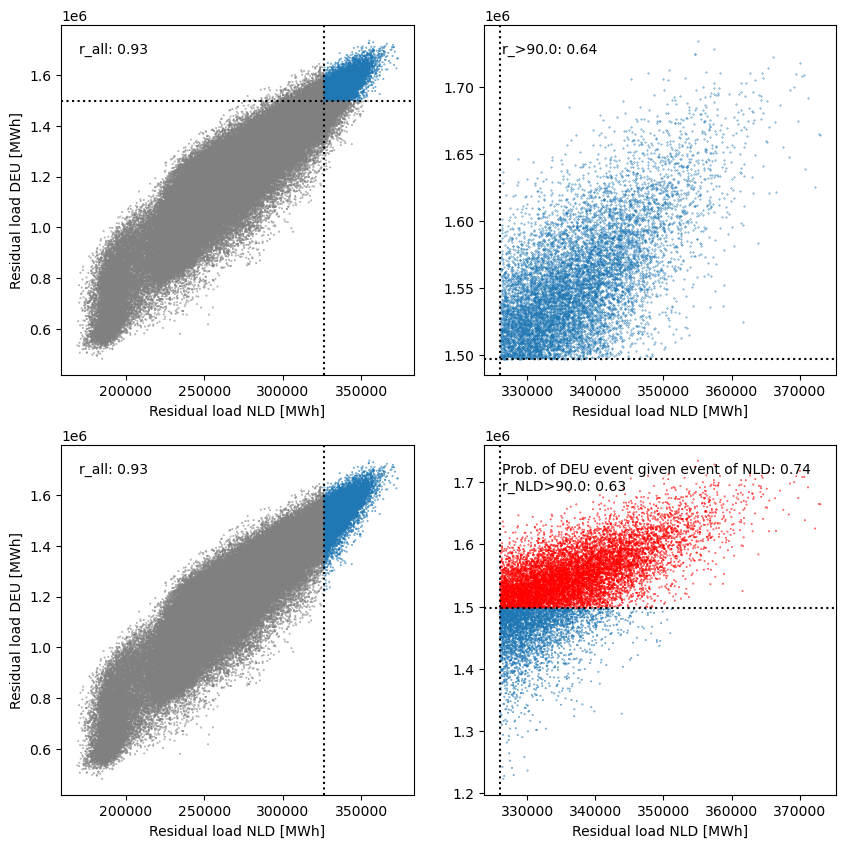

In [5]:
calc_cooccur('NLD', 'DEU', 0.9, plot = True)

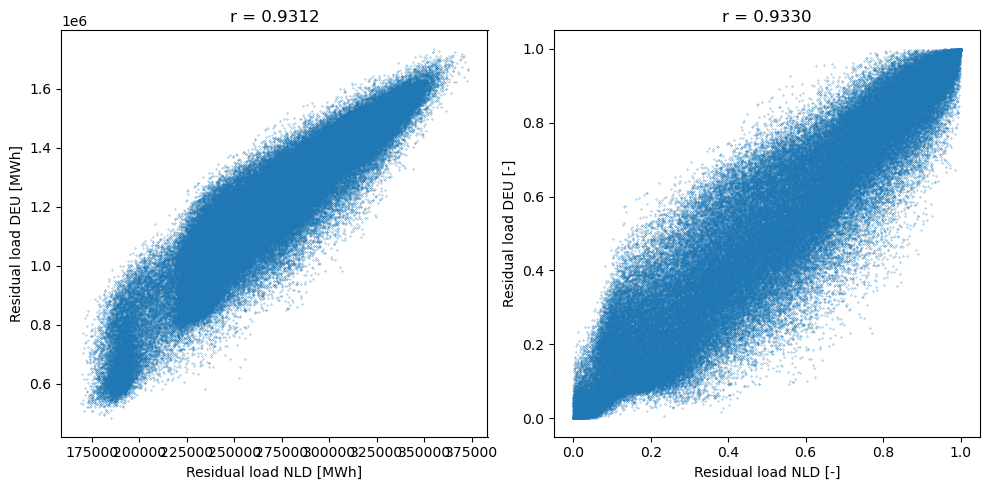

In [30]:
c1_name = 'NLD'
c2_name = 'DEU'
c1 = data_stacked.sel(country = country_name_nr[c1_name])
c2 = data_stacked.sel(country = country_name_nr[c2_name])

# now convert to uniform marginals
c1_rank = c1.rank(dim = 'event', pct = True)
c2_rank = c2.rank(dim = 'event', pct = True)

# First plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f'r = {np.corrcoef(c1, c2)[0, 1]:.4f}')
plt.scatter(c1, c2, s=0.05)
plt.xlabel(f'Residual load {c1_name} [MWh]')
plt.ylabel(f'Residual load {c2_name} [MWh]')

# Second plot
plt.subplot(1, 2, 2)
plt.title(f'r = {np.corrcoef(c1_rank, c2_rank)[0, 1]:.4f}')
plt.scatter(c1_rank, c2_rank, s=0.05)
plt.xlabel(f'Residual load {c1_name} [-]')
plt.ylabel(f'Residual load {c2_name} [-]')

# Adjust layout for better appearance
plt.tight_layout()

#### Chi is a quantile-dependent measure of dependence! See Coles et al. 1999 EQ. 3.2

In [7]:
def get_chi(c1, c2, u):
    # chi == 0 means random, chi > 0 means chance larger than random, chi < 0 means chance smaller than random
    cond_c1 = c1 < u
    cond_c2 = c2 < u
    cond_both = cond_c1 & cond_c2
    X = np.log(sum(cond_both) / len(c1))
    Y = np.log(sum(cond_c1) / len(c1))
    # X_bar = np.mean(X)
    # Y_bar = np.mean(Y)
    # X_var = np.var(X)
    # Y_var = np.var(Y)
    # cov_XY = np.cov(X, Y)[0, 1]
    chi = 2 - X / Y
    # var_ratio = 
    return chi

In [8]:
def get_chi_bar(c1, c2, u):
    cond_c1 = c1 > u
    cond_c2 = c2 > u
    cond_both = cond_c1 & cond_c2
    X = np.log(sum(cond_c1) / len(c1))
    Y = np.log(sum(cond_both) / len(c1))
    chi_bar = 2*X/Y - 1
    return chi_bar

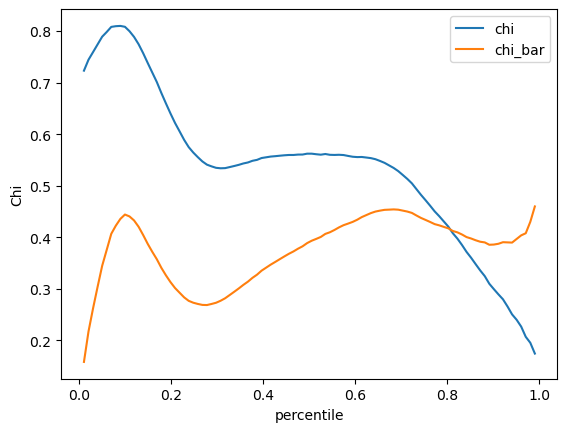

In [9]:
# STILL WANT TO ADD CONFIDENCE INTERVALS HERE, USING 'THE DELTA METHOD' BUT HAVE TO READ A BIT MORE ON THAT, SEE DAILY_NOTE!

u_arr = np.linspace(0.01, 0.99, 100)

# c1_name = 'NLD'
# c2_name = 'POL'
# c1 = data_stacked.sel(country = country_name_nr[c1_name])
# c2 = data_stacked.sel(country = country_name_nr[c2_name])

# # now convert to uniform marginals
# c1_rank = c1.rank(dim = 'event', pct = True)
# c2_rank = c2.rank(dim = 'event', pct = True)

chi = [get_chi(c1_rank.values, c2_rank.values, u) for u in u_arr]
chi_bar = [get_chi_bar(c1_rank.values, c2_rank.values, u) for u in u_arr]
plt.plot(u_arr, chi, label = 'chi')
plt.plot(u_arr, chi_bar, label = 'chi_bar')
plt.xlabel('percentile')
plt.ylabel('Chi')
plt.legend()

### Messing around with copula

In [34]:
from copulas.multivariate import GaussianMultivariate
copula = GaussianMultivariate()

In [44]:
def copula_vs_raw(c1_name, c2_name, thres):
    c1 = data_stacked.sel(country = country_name_nr[c1_name])
    c2 = data_stacked.sel(country = country_name_nr[c2_name])
    # now convert to uniform marginals
    c1_rank = c1.rank(dim = 'event', pct = True)
    c2_rank = c2.rank(dim = 'event', pct = True)

    data = pd.DataFrame({
    'c1_rank': c1_rank.values,
    'c2_rank': c2_rank.values
    })  
    copula.fit(data)
    num_samples = 100000
    samples = copula.sample(num_samples)
    prob_raw = calc_cooccur_v2(c1_rank, c1_name, c2_rank, c2_name, thres, plot = True)
    prob_copula = calc_cooccur_v2(samples['c1_rank'], c1_name, samples['c2_rank'], c2_name, thres, plot = True)
    print(f'Probability based on raw data: {prob_raw:.4f}, probability based on copula: {prob_copula:.4f}')

/usr/people/duinen/anaconda3_v2/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:5574: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/usr/people/duinen/anaconda3_v2/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in scalar multiply
  Lhat = muhat - Shat*mu


Probability based on raw data: 0.3852, probability based on copula: 0.4270


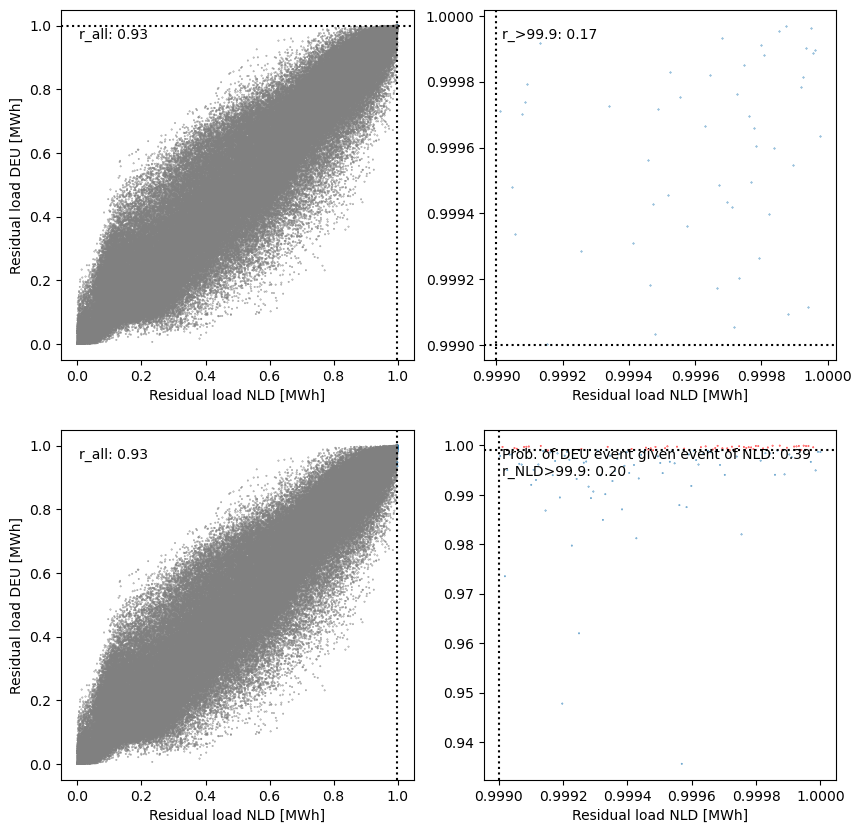

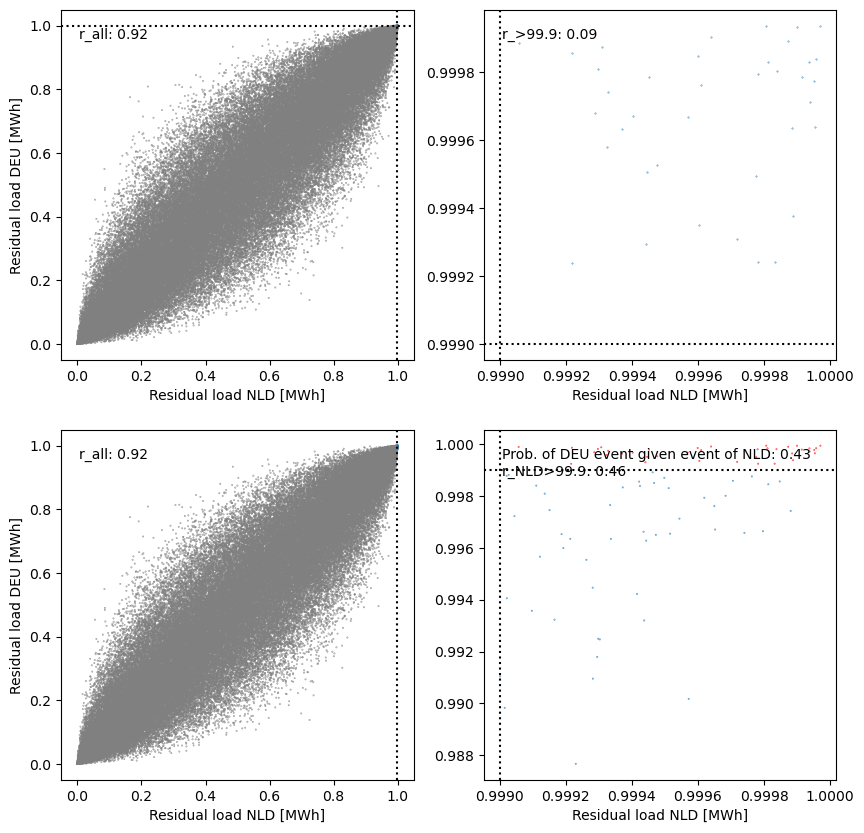

In [45]:
copula_vs_raw('NLD', 'DEU', 0.999)

In [35]:
data = pd.DataFrame({
    'c1_rank': c1_rank.values,
    'c2_rank': c2_rank.values
})

In [36]:
copula.fit(data)

/usr/people/duinen/anaconda3_v2/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:5574: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/usr/people/duinen/anaconda3_v2/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in scalar multiply
  Lhat = muhat - Shat*mu


In [37]:
num_samples = 100000
samples = copula.sample(num_samples)

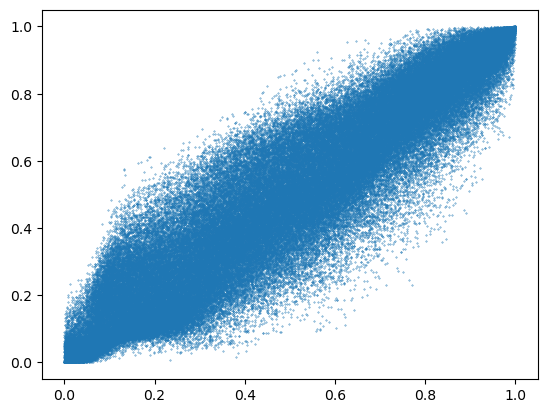

In [38]:
plt.scatter(c1_rank, c2_rank, s = 0.1)

<xarray.DataArray 'residual' ()>
array(0.73981867)
Coordinates:
    country       float64 9.0
    country_name  <U3 'DEU'

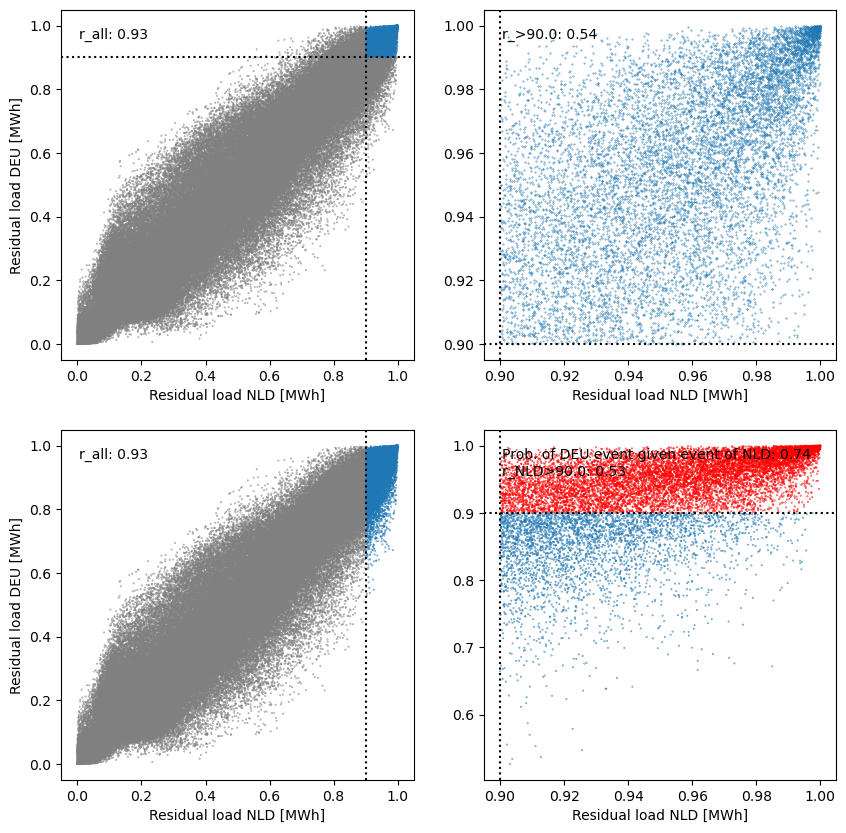

In [32]:
calc_cooccur_v2(c1_rank, 'NLD', c2_rank, 'DEU', 0.9, plot = True)

0.7378036737112385

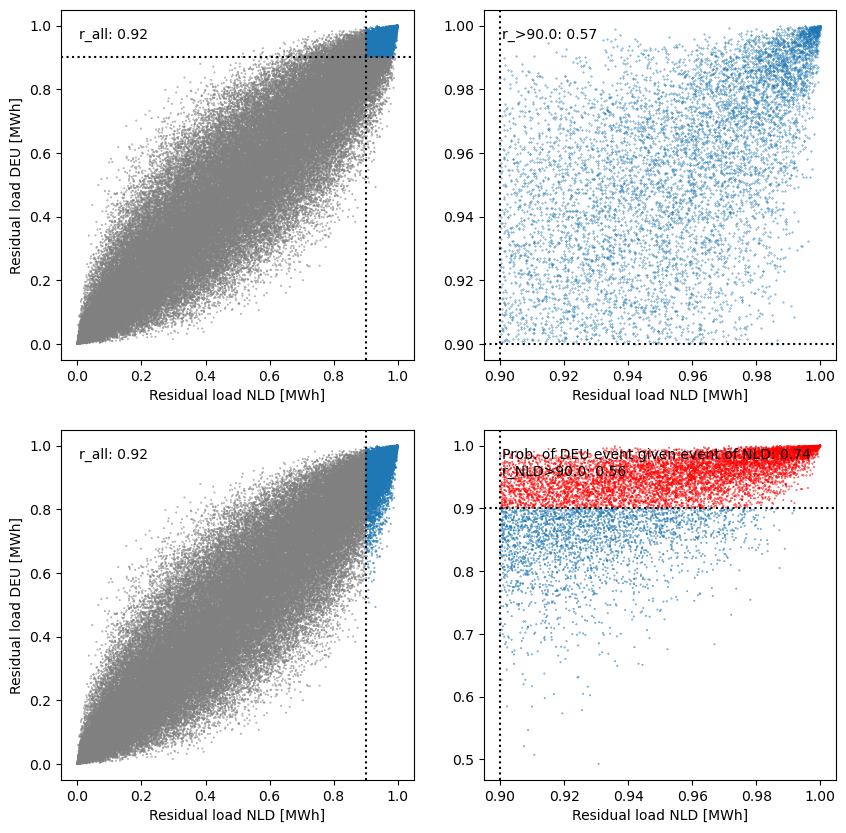

In [39]:
calc_cooccur_v2(samples['c1_rank'], 'NLD', samples['c2_rank'], 'DEU', 0.9, plot = True)

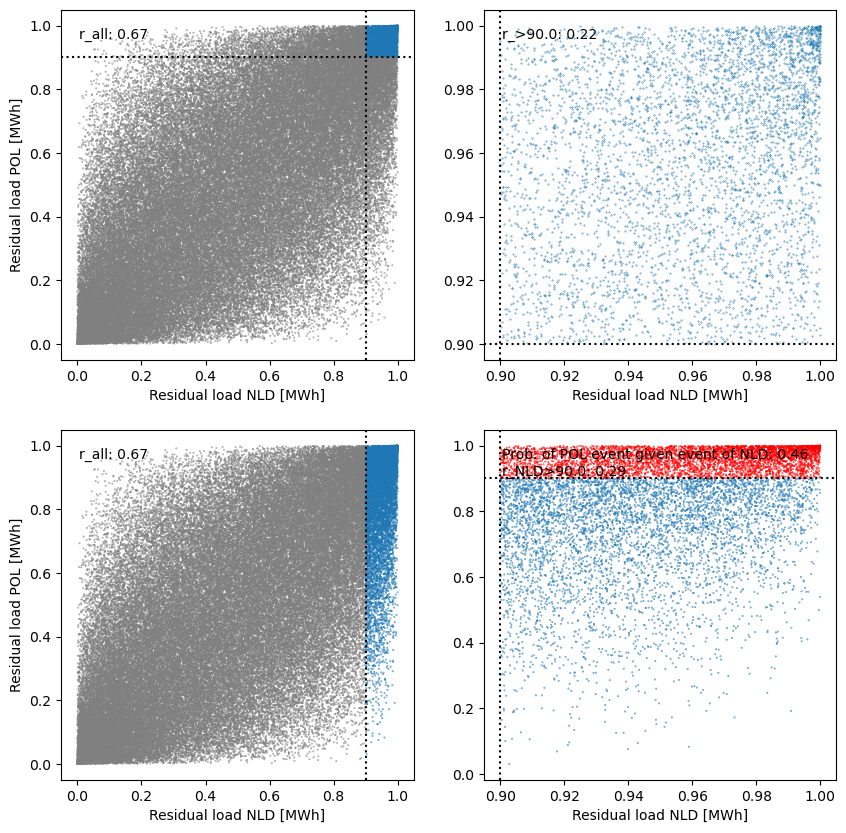

In [19]:
c1, c2 = samples['c1_rank'], samples['c2_rank']
plot = True

# Compute conditions once and reuse
thres_c1, thres_c2 = 0.9, 0.9

cond_c1 = c1 > thres_c1
cond_c2 = c2 > thres_c2
cond_both = cond_c1 & cond_c2

colors = np.where(cond_both, 'C0', 'grey')

# Calculate the correlation coefficient for the complete residual load
corr_all = np.corrcoef(c1, c2)[0, 1]

# Filter the parts above the 90th percentile
c1_both_above_thres = c1[cond_both]
c2_both_above_thres = c2[cond_both]

# Calculate the correlation coefficient for the parts above the 90th percentile
corr_both_above_thres = np.corrcoef(c1_both_above_thres, c2_both_above_thres)[0, 1]

# Filter the parts above the 90th percentile of c1
c1_above_thres = c1[cond_c1]
c2_above_c1thres = c2[cond_c1]

# Calculate the correlation coefficient for the parts above the 90th percentile
corr_above_c1thres = np.corrcoef(c1_above_thres, c2_above_c1thres)[0, 1]

num_c1_events = len(c1_above_thres)
num_c2_events_given_c1 = np.sum(c2_above_c1thres > thres_c2)
prob = num_c2_events_given_c1 / num_c1_events

if plot == True:
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Create a subplot with 2 rows and 2 columns

    # First plot
    axs[0, 0].scatter(c1, c2, s = 0.1, c=colors)
    axs[0, 0].axvline(x=thres_c1, color='k', linestyle='dotted')
    axs[0, 0].axhline(y=thres_c2, color='k', linestyle='dotted')
    axs[0, 0].text(0.05, 0.95, f'r_all: {corr_all:.2f}', transform=axs[0, 0].transAxes, verticalalignment='top')
    axs[0, 0].set_xlabel(f'Residual load {c1_name} [MWh]')
    axs[0, 0].set_ylabel(f'Residual load {c2_name} [MWh]')

    # Second plot
    axs[0, 1].scatter(c1_both_above_thres, c2_both_above_thres, s = 0.1)
    axs[0, 1].axhline(y=thres_c2, color='k', linestyle='dotted')
    axs[0, 1].axvline(x=thres_c1, color='k', linestyle='dotted')
    axs[0, 1].text(0.05, 0.95, f'r_>{thres_c1*100}: {corr_both_above_thres:.2f}', transform=axs[0, 1].transAxes, verticalalignment='top')
    axs[0, 1].set_xlabel(f'Residual load {c1_name} [MWh]')

    colors_c1 = np.where((c1 > thres_c1), 'C0', 'grey')

    # Third plot
    axs[1, 0].scatter(c1, c2, s = 0.1, c=colors_c1)
    axs[1, 0].axvline(x=thres_c1, color='k', linestyle='dotted')
    axs[1, 0].text(0.05, 0.95, f'r_all: {corr_all:.2f}', transform=axs[1, 0].transAxes, verticalalignment='top')
    axs[1, 0].set_xlabel(f'Residual load {c1_name} [MWh]')
    axs[1, 0].set_ylabel(f'Residual load {c2_name} [MWh]')

    # Create a color array for the fourth plot
    colors_c2 = np.where((c2_above_c1thres > thres_c2), 'red', 'C0')

    axs[1, 1].scatter(c1_above_thres, c2_above_c1thres, s = 0.1, c=colors_c2)
    axs[1, 1].axhline(y=thres_c2, color='k', linestyle='dotted')
    axs[1, 1].axvline(x=thres_c1, color='k', linestyle='dotted')
    axs[1, 1].text(0.05, 0.90, f'r_{c1_name}>{thres_c1*100}: {corr_above_c1thres:.2f}', transform=axs[1, 1].transAxes, verticalalignment='top')
    axs[1, 1].text(0.05, 0.95, f"Prob. of {c2_name} event given event of {c1_name}: {prob:.2f}", transform=axs[1, 1].transAxes, verticalalignment='top')
    axs[1, 1].set_xlabel(f'Residual load {c1_name} [MWh]')

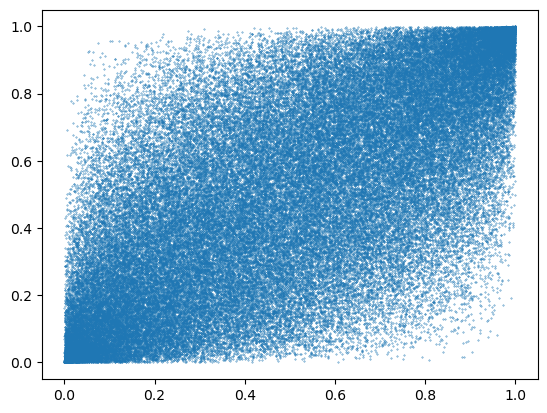

In [16]:
plt.scatter(samples['c1_rank'], samples['c2_rank'], s = 0.1)

/tmp/ipykernel_1685235/2690534793.py:5: RuntimeWarning: divide by zero encountered in log
  X = np.log(sum(cond_c1) / len(c1))
/tmp/ipykernel_1685235/2690534793.py:6: RuntimeWarning: divide by zero encountered in log
  Y = np.log(sum(cond_both) / len(c1))
/tmp/ipykernel_1685235/2690534793.py:7: RuntimeWarning: invalid value encountered in scalar divide
  chi_bar = 2*X/Y - 1
/tmp/ipykernel_1685235/2035093215.py:13: RuntimeWarning: invalid value encountered in scalar divide
  chi = 2 - X / Y


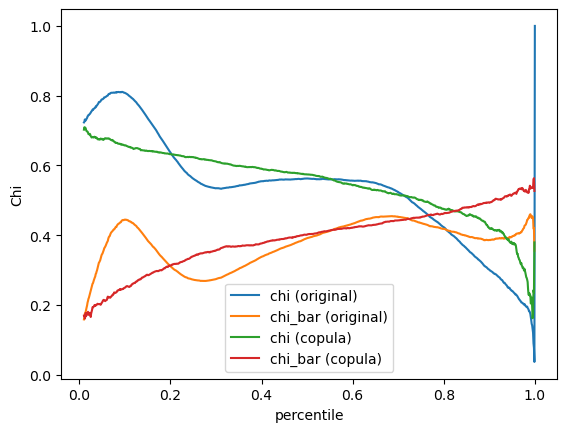

In [14]:
u_arr = np.linspace(0.01, 1, 1000)

chi = [get_chi(c1_rank.values, c2_rank.values, u) for u in u_arr]
chi_bar = [get_chi_bar(c1_rank.values, c2_rank.values, u) for u in u_arr]
plt.plot(u_arr, chi, label = 'chi (original)')
plt.plot(u_arr, chi_bar, label = 'chi_bar (original)')
plt.xlabel('percentile')
plt.ylabel('Chi')
plt.legend()

chi = [get_chi(samples['c1_rank'], samples['c2_rank'], u) for u in u_arr]
chi_bar = [get_chi_bar(samples['c1_rank'], samples['c2_rank'], u) for u in u_arr]
plt.plot(u_arr, chi, label = 'chi (copula)')
plt.plot(u_arr, chi_bar, label = 'chi_bar (copula)')
plt.xlabel('percentile')
plt.ylabel('Chi')
plt.legend()

In [41]:
copula.to_dict()

{'correlation': [[1.0, 0.689647561310284], [0.689647561310284, 1.0]],
 'univariates': [{'loc': 7.431629013079667e-06,
   'scale': 0.9999925683709869,
   'type': 'copulas.univariate.uniform.UniformUnivariate'},
  {'loc': 7.431629013079667e-06,
   'scale': 0.9999888525564804,
   'type': 'copulas.univariate.uniform.UniformUnivariate'}],
 'columns': ['c1_rank', 'c2_rank'],
 'type': 'copulas.multivariate.gaussian.GaussianMultivariate'}

In [30]:
from copulas.visualization import dist_1d

dist_1d(data['c1_rank'], title='c1_rank')

In [29]:

c1_cdf = copula.univariates[0].cdf(data['c1_rank'])
dist_1d(c1_cdf, title='c1_rank')

In [65]:
u_arr = np.linspace(0.01, 0.999, 100)

# c1_name = 'NLD'
for i, c1_name in tqdm(enumerate(COUNTRY_NAME)):
    c1 = data_stacked.sel(country = country_name_nr[c1_name])
    c1_rank = c1.rank(dim = 'event', pct = True)
    chi_arr = np.zeros((len(COUNTRY_NAME), len(u_arr)))
    labels = []
    extreme_dependence = []
    for j, c2_name in enumerate(COUNTRY_NAME):
        c2 = data_stacked.sel(country = country_name_nr[c2_name])
        c2_rank = c2.rank(dim = 'event', pct = True)
        chi_arr[j] = np.asarray([get_chi(c1_rank.values, c2_rank.values, u) for u in u_arr])
        labels.append(c2_name)
        extreme_dependence.append(np.mean(chi_arr[j, 80:99]))

    highest_dependence = np.argsort(extreme_dependence)[-4:][::-1]
    lowest_dependence = np.argsort(extreme_dependence)[:3]

    plt.figure()
    for i in highest_dependence[1:]: # skip the highest, because that is country with itself!
        plt.plot(u_arr, chi_arr[i], label = labels[i])
    for i in lowest_dependence:
        plt.plot(u_arr, chi_arr[i], label = labels[i])

    plt.title(f'Chi as a function of percentile for {c1_name}')    
    plt.xlabel('Percentile')
    plt.ylabel('Chi')
    plt.legend()
    plt.savefig(f'{dir_Figures}chi_{c1_name}.png', dpi = 300)
    plt.close()

0it [00:00, ?it/s]

/tmp/ipykernel_842911/2035093215.py:6: RuntimeWarning: divide by zero encountered in log
  X = np.log(sum(cond_both) / len(c1))


In [6]:
def calc_prob(thres, threstype):
    """
    Calculate the co-occurrence probability matrix and create a DataFrame for co-occurrence analysis between different countries. The function iterates through pairs of countries, calculates the co-occurrence probability using the `calc_cooccur` function,
    and populates the probability matrix and DataFrame accordingly. The results are saved as a NumPy array and a CSV file.

    Parameters:
        thres (float): Threshold value for an energy drought event.
        threstype (str): Threshold value, used for saving the data.

    Returns:
        tuple: Tuple containing the probability matrix and DataFrame.
            - prob_matrix (numpy.ndarray): Matrix storing the probabilities of events in one country given events in another.
            - df_cooccurrence (pandas.DataFrame): DataFrame with all the co-occurrence probabilities.
    """
    prob_matrix = np.zeros((len(COUNTRY_NR), len(COUNTRY_NR)))

    columns = ['Country_1', 'Country_2', 'p_co']
    data = np.empty((len(COUNTRY_NR)**2, 3), dtype=object)

    for i, c1_name in tqdm(enumerate(COUNTRY_NAME)):
        for j, c2_name in enumerate(COUNTRY_NAME):
            prob = calc_cooccur(c1_name, c2_name, thres)
            prob_matrix[i, j] = prob
            data[i*len(COUNTRY_NAME)+j] = [c1_name, c2_name, prob]

    df_cooccurrence = pd.DataFrame(data, columns=columns)

    np.save(f'{dir_Output}{threstype}.npy', prob_matrix)
    df_cooccurrence.to_csv(f'{dir_Output}{threstype}_df.csv', index=False)
    return prob_matrix, df_cooccurrence

In [7]:
def reorder(matrix):
    """
    Reorder a matrix based on predefined row order.

    Parameters:
        matrix (numpy.ndarray): Input matrix to be reordered.

    Returns:
        numpy.ndarray: Reordered matrix based on predefined row order.
    """
    df_matrix = pd.DataFrame(matrix)

    matrix_reordered = df_matrix.reindex(ROW_ORDER, axis=0)
    matrix_reordered = matrix_reordered.reindex(ROW_ORDER, axis=1)
    return matrix_reordered.values

### 3. Perform co-occurrence analysis

In [8]:
prob_matrix09, df_09 = calc_prob(0.9, '90perc')
prob_matrix095, df_095 = calc_prob(0.95, '95perc')
prob_matrix0975, df_0975 = calc_prob(0.975, '97_5perc')
prob_matrix099, df_099 = calc_prob(0.99, '99perc')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

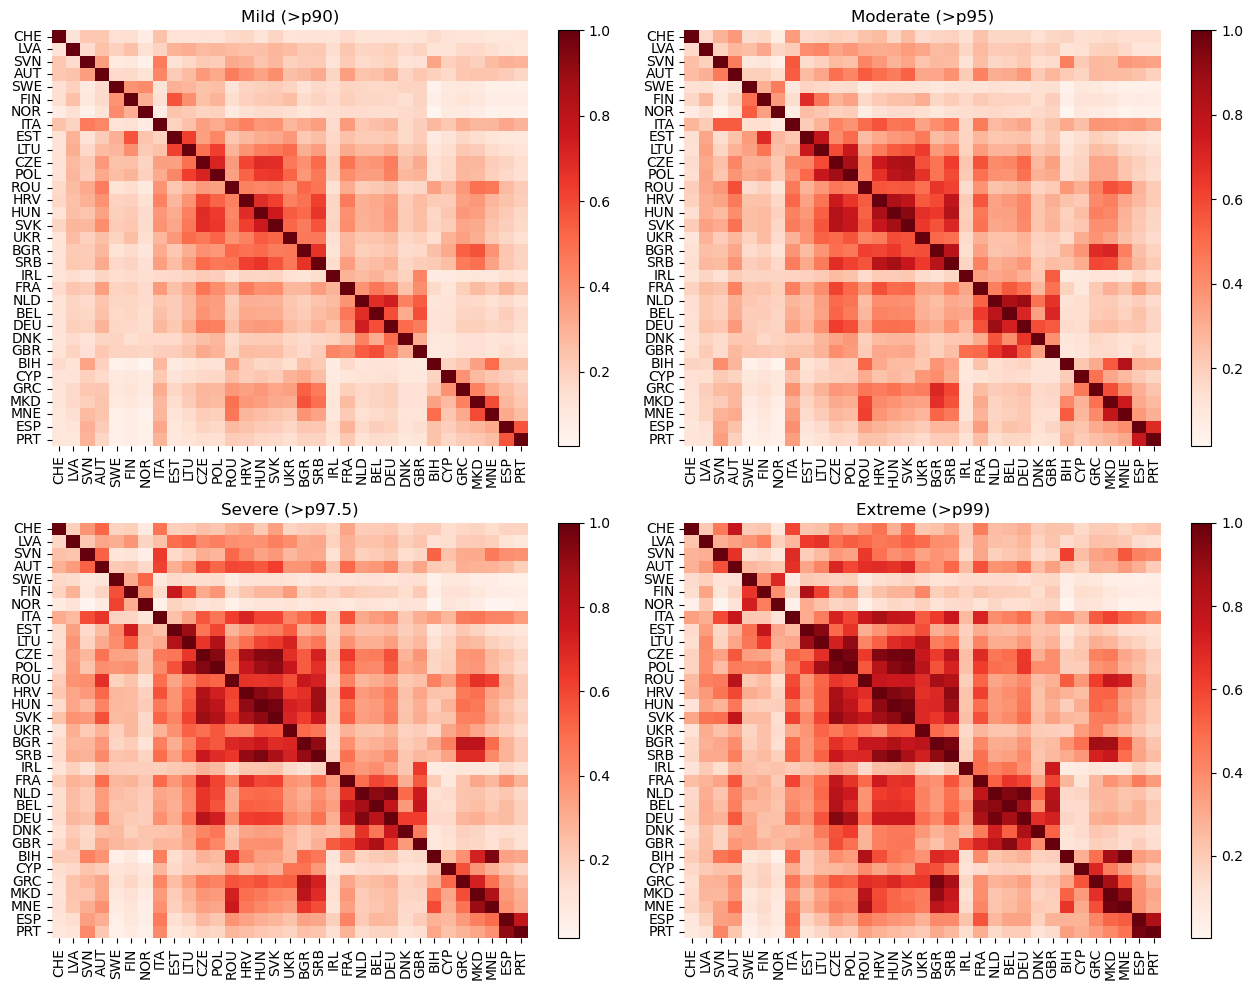

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(13, 10))

matrix_list = [prob_matrix09, prob_matrix095, prob_matrix0975, prob_matrix099]
type_list = ['mild', 'moderate', 'severe', 'extreme']
drought_types = ['Mild (>p90)', 'Moderate (>p95)', 'Severe (>p97.5)', 'Extreme (>p99)']

for ax, matrix, title, threstype in zip(axs.flatten(), matrix_list, drought_types, type_list):
    hm = sns.heatmap(reorder(matrix), cmap='Reds', cbar = False, xticklabels=COUNTRY_NAME[ROW_ORDER], 
                yticklabels=COUNTRY_NAME[ROW_ORDER], ax=ax)
    ax.set_title(title)
    plt.colorbar(hm.collections[0], ax=ax)

plt.tight_layout()
plt.savefig(f'{dir_Figures}heatmap_probabilities.png', dpi=300)